In [1]:
beetles_data <- read.csv(file="./beetles.csv", header=TRUE)

 head(beetles_data)

,days,beetles
,<int>,<int>
1,0,2
2,8,47
3,28,192
4,41,256
5,63,768
6,79,896


In [2]:
t <- beetles_data$days
y <- beetles_data$beetles

sprintf("Number of days: %d", length(t))
sprintf("Number of beetles: %d", length(y))

[1] "Number of days: 10"

[1] "Number of beetles: 10"

In [3]:
N0 <- y[1]

population_func <- function(t, k, r) {
    k*N0 / (N0 + (k - N0)*exp(-r*t))
}

In [4]:
loss_func <- function(t, y, params) {
    y_pred <- population_func(t, params$k, params$r)
    total <- mean((y_pred - y)^2)
    
    total / 2
}

In [6]:
h_prime_func <- function(t, params) {
    exp_rt <- exp(-params$r*t)
    h_prime_k <- exp_rt
    h_prime_r <- -t*(params$k - N0)*exp_rt

    list(k=h_prime_k, r=h_prime_r)
}

g_prime_func <- function(t, params) {
    exp_rt <- exp(-params$r*t)
    h <- N0 + (params$k - N0)*exp_rt
    h_prime <- h_prime_func(t, params)

    g_prime_k <- N0/h - h_prime$k*(params$k*N0)/h^2
    g_prime_r <- -(params$k*N0/h^2)*h_prime$r

    list(k=g_prime_k, r=g_prime_r)
}

loss_prime_func <- function(t, y, params) {
    y_hat <- population_func(t, params$k, params$r)
    g_prime <- g_prime_func(t, params)
    delta <- y_hat - y

    loss_prime_k <- mean(delta*g_prime$k)
    loss_prime_r <- mean(delta*g_prime$r)

    c(loss_prime_k, loss_prime_r)
}

In [7]:
h_2prime_func <- function(t, params) {
    h_2prime_rr <- (t^2)*(params$k - N0)*exp(-params$r*t)
    h_2prime_rk <- -t*exp(-params$r*t)

    list(kk=0, rr=h_2prime_rr, rk=h_2prime_rk)
}

g_2prime_func <- function(t, params) {
    exp_rt <- exp(-params$r*t)
    h <- N0 + (params$k - N0)*exp_rt
    h_prime <- h_prime_func(t, params)
    h_2prime <- h_2prime_func(t, params)
    KN0 <- params$k*N0

    g_2prime_kk <- 2*(h_prime$k^2)*(KN0/h^3) - 2*h_prime$k*(N0/h^2)
    g_2prime_rr <- 2*(KN0/h^3)*h_prime$r^2 - (KN0/h^2)*h_2prime$rr
    g_2prime_rk <- -(N0/h^2)*h_prime$r - (KN0/h^2)*h_2prime$rk + 2*(KN0/h^3)*h_prime$k*h_prime$r

    list(kk=g_2prime_kk, rr=g_2prime_rr, rk=g_2prime_rk)
}

loss_2prime_func <- function(t, y, params) {
    y_hat <- population_func(t, params$k, params$r)
    g_prime <- g_prime_func(t, params)
    g_2prime <- g_2prime_func(t, params)
    delta <- y_hat - y

    loss_2prime_kk <- mean(delta*g_2prime$kk + g_prime$k^2)
    loss_2prime_rr <- mean(delta*g_2prime$rr + g_prime$r^2)
    loss_2prime_rk <- mean(delta*g_2prime$rk + g_prime$k*g_prime$r)

    rbind(
        c(loss_2prime_kk, loss_2prime_rk),
        c(loss_2prime_rk, loss_2prime_rr)
    )
}

### Naive Newton method

In [8]:
newtonlike_updating <- function(params, M, grad, a=1.) {
    d <- -solve(M,grad)
    
    params$k <- params$k + a*d[1]
    params$r <- params$r + a*d[2]
    return(params)
}

update_history <- function(history, iter, loss) {
    history$iter <- append(history$iter, iter)
    history$loss <- append(history$loss, loss)

    history
}

err_func <- function(old_params, params) {
    old_params <- c(old_params$k, old_params$r)
    params <- c(params$k, params$r)

    norm(params - old_params, type="2")
}

In [9]:
newton_optimizer <- function(t, y, max_iter, threshold, params, start_a=0.5) {
    history <- list(iter=list(), loss=list())
    init_loss <- loss_func(t, y, params)
    history <- update_history(history, 0, init_loss)
    a <- start_a
    
    for (i in 1:max_iter) {
        iter <- i
        old_params <- params
        grad <- loss_prime_func(t, y, old_params)
        M <- loss_2prime_func(t, y, old_params)
        params <- newtonlike_updating(old_params, M, grad, a)
        
        new_loss <- loss_func(t, y, params)
        history <- update_history(history, iter, new_loss)
        
        err <- err_func(old_params, params)
        if (err <= threshold) {
            print(sprintf("Stop at iter: %d", iter))
            break
        }
    }
    return(list(params=params, history=history))
}

[1] "Stop at iter: 27"


[1] "Optimal points: K=1033.5153, r=0.1180"

[1] "Final loss: 4162.0243"

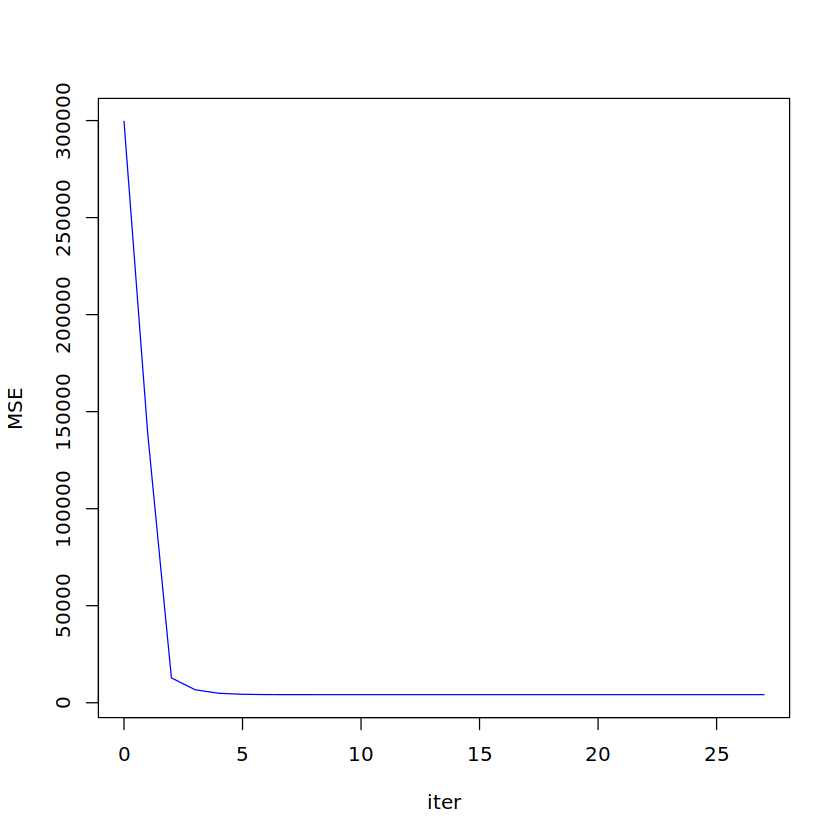

In [10]:
max_iter <- 100
threshold <- 1e-5
start_a <- 0.5
init_params <- list(k = 1.,r = 1.)

result <- newton_optimizer(t, y, max_iter, threshold, init_params, start_a)

plot(
    result$history$iter,
    result$history$loss,
    type = "l",
    col = "blue",
    xlab = 'iter',
    ylab = 'MSE'
)

sprintf("Optimal points: K=%.4f, r=%.4f", result$params$k, result$params$r)
sprintf("Final loss: %.4f",loss_func(t, y, result$params))

### Quasi-Newton method

In [11]:
hess_updating <- function(t, y, params, old_params, M, old_grad) {
    grad <- loss_prime_func(t, y, params)

    # convert list to vector
    params <- c(params$k, params$r)
    old_params <- c(old_params$k, old_params$r)
    
    h <- params - old_params
    u <- grad - old_grad
    h_trans <- t(h)
    m_h <- M %*% h
    num1 <- m_h %*% t(m_h)
    de1 <- as.numeric(h_trans %*% m_h)
    num2 <- u %*% t(u)
    de2 <- as.numeric(h_trans %*% u)

    M <- M - num1/de1 + num2/de2
}

bfgs_optimizer <- function(t, y, max_iter, threshold, params, M, start_a=1) {
    history <- list(iter=list(), loss=list())
    init_loss <- loss_func(t, y, params)
    history <- update_history(history, 0, init_loss)
    
    for (i in 1:max_iter) {
        iter <- i
        a <- start_a
        old_params <- params
        old_loss <- loss_func(t, y, old_params)
        grad <- loss_prime_func(t, y, old_params)
        params <- newtonlike_updating(old_params, M, grad, a)

        for (j in 1:10) {
            new_loss <- loss_func(t, y, params)
            if (new_loss < old_loss) {
                break
            }
            a <- a / 2.
            params <- newtonlike_updating(old_params, M, grad, a)
        }
        history <- update_history(history, iter, new_loss)
        
        err <- err_func(old_params, params)
        if (err <= threshold) {
            print(sprintf("Stop at iter: %d", iter))
            break
        }
        M <- hess_updating(t, y, params, old_params, M, grad)
    }

    return(list(params=params, history=history))
}

[1] "Stop at iter: 28"


[1] "Optimal points: K=709.2222, r=32.8940"

[1] "Final loss: 73896.5778"

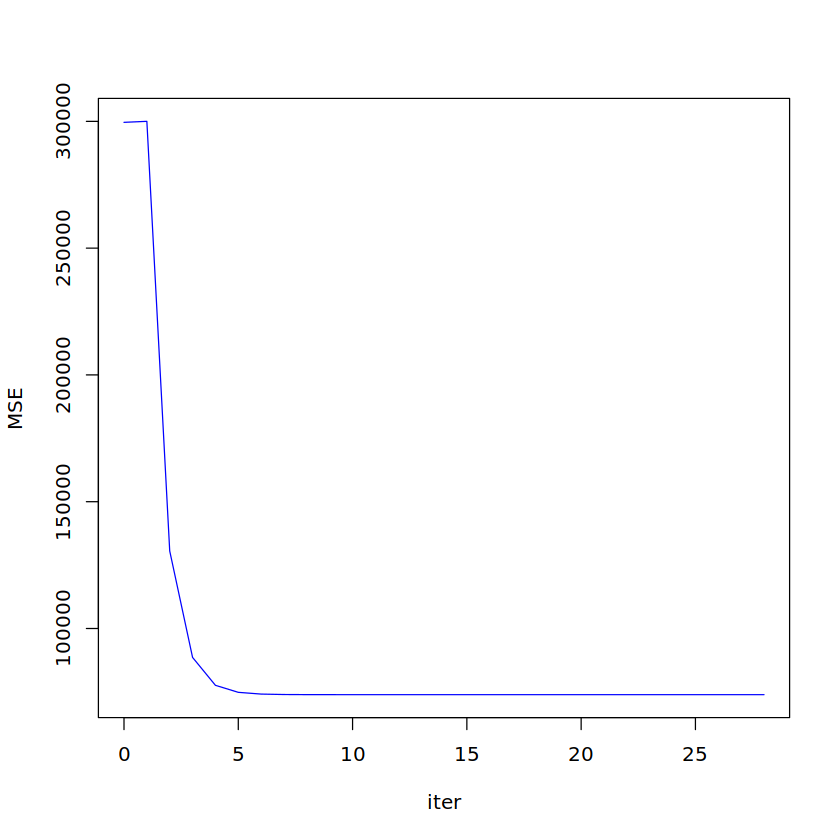

In [15]:
max_iter <- 100
threshold <- 1e-5

init_params <- list(k = 1.,r = 1.)
start_a <- 0.5
M <- -diag(c(1,1), 2, 2)

result <- bfgs_optimizer(t, y, max_iter, threshold, init_params, M, start_a)
plot(
    result$history$iter,
    result$history$loss,
    type = "l",
    col = "blue",
    xlab = 'iter',
    ylab = 'MSE'
)

sprintf("Optimal points: K=%.4f, r=%.4f", result$params$k, result$params$r)
sprintf("Final loss: %.4f",loss_func(t, y, result$params))